In [3]:
# importação de pacotes
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
print("Versão do TensorFlow: ", tf.__version__)

import PIL
import imageio
from IPython import display

Versão do TensorFlow:  2.8.0


In [7]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

DATA_FOLDERS = [os.sep.join(["datasets", name, "train"]) for name in ["tiny-hero", "rpg-maker-2000"]]
TRAIN_SIZE = int(sum([3104, 184]))
TEST_SIZE = int(sum([]))
BATCH_SIZE = 64 
IMAGE_SIZE = 64
CHANNELS = 4
EPOCHS = 50

In [8]:
class_names = []
X_train = [0, 1]
for i in range(2):
    X_train[i] = keras.preprocessing.image_dataset_from_directory(
        DATA_FOLDERS[i],
        class_names = ["0-back", "1-left", "2-front", "3-right"],
        label_mode= "int",
        color_mode="rgba",
        interpolation="nearest",
        seed=SEED,
        batch_size=BATCH_SIZE,
        image_size=(IMAGE_SIZE, IMAGE_SIZE))
    class_names = X_train[i].class_names
X_train = X_train[0].concatenate(X_train[1])

X_validation = [0, 1]
for i in range(2):
    X_validation[i] = keras.preprocessing.image_dataset_from_directory(
        DATA_FOLDERS[i],
        class_names = ["0-back", "1-left", "2-front", "3-right"],
        label_mode= "int",
        color_mode="rgba",
        interpolation="nearest",
        seed=SEED,
        batch_size=BATCH_SIZE,
        image_size=(IMAGE_SIZE, IMAGE_SIZE))
X_validation = X_validation[0].concatenate(X_validation[1])


normalization_layer = keras.layers.experimental.preprocessing.Rescaling(1./127.5, -1)
X_train = X_train.map(lambda x, y: (normalization_layer(x), y)).shuffle(TRAIN_SIZE)
X_validation = X_validation.map(lambda x, y: (normalization_layer(x), y))

Found 3104 files belonging to 4 classes.
Found 736 files belonging to 4 classes.
Found 3104 files belonging to 4 classes.
Found 736 files belonging to 4 classes.


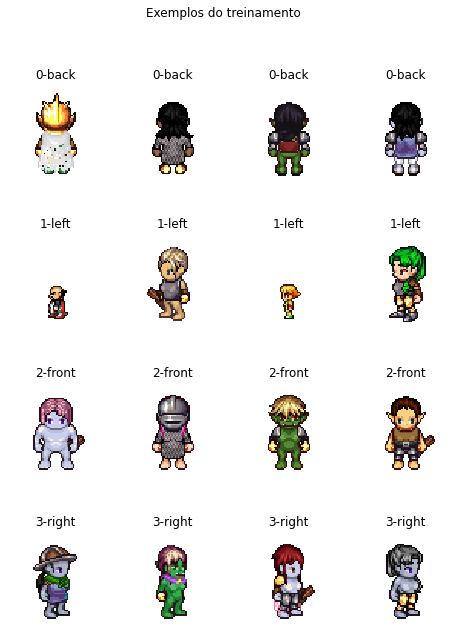

In [9]:
def denormalize_image(image):
    return (image + 1) / 2

def show_image(image):
    plt.imshow(image, interpolation="nearest")
    
def show_normalized_image(image):
    show_image(denormalize_image(image))

plt.figure(figsize=(8, 9))
plt.suptitle("Exemplos do treinamento")
plt.subplots_adjust(bottom=0)
for i in range(4):
    X_train_by_class = X_train.filter(lambda x, l: tf.math.equal(l[0], i))
    for j in range(4):
        for images, labels in X_train_by_class.take(1):
            ax = plt.subplot(4, 4, (i*4+j)+1)
            show_normalized_image(images[0])
            plt.title(class_names[labels[0]])
            plt.axis("off")

In [10]:
X_train = X_train.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
X_validation = X_validation.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [11]:
pose_classifier = keras.Sequential([
    layers.Conv2D(2, 3, padding="same", activation="relu", input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),
    layers.Conv2D(8, 3, strides=2, padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.8),
    
    layers.Flatten(),
    layers.Dense(128),
    layers.Dense(len(class_names), activation="softmax")
#     layers.Conv2D(32, 3, padding="same", activation="relu", input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),
#     layers.MaxPool2D(),
#     layers.Dropout(0.8),

#     layers.Flatten(),
#     layers.Dense(24),
#     layers.Dense(len(class_names), activation="softmax")
])

pose_classifier.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

pose_classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 2)         74        
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 8)         152       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 8)        32        
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 32, 32, 8)         0         
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 128)               1048704   
                                                        

In [12]:
history = pose_classifier.fit(
  X_train,
  validation_data=X_validation,
  epochs=EPOCHS,
)

Epoch 1/50
61/61 [==============================] - 11s 35ms/step - loss: 1.1274 - accuracy: 0.8409 - val_loss: 0.3408 - val_accuracy: 0.9354
Epoch 2/50
61/61 [==============================] - 1s 15ms/step - loss: 0.4567 - accuracy: 0.9276 - val_loss: 0.2736 - val_accuracy: 0.9766
Epoch 3/50
61/61 [==============================] - 1s 15ms/step - loss: 0.3788 - accuracy: 0.9349 - val_loss: 0.1681 - val_accuracy: 0.9888
Epoch 4/50
61/61 [==============================] - 1s 16ms/step - loss: 0.2456 - accuracy: 0.9495 - val_loss: 0.1167 - val_accuracy: 0.9883
Epoch 5/50
61/61 [==============================] - 1s 15ms/step - loss: 0.2587 - accuracy: 0.9474 - val_loss: 0.0799 - val_accuracy: 0.9880
Epoch 6/50
61/61 [==============================] - 1s 15ms/step - loss: 0.2049 - accuracy: 0.9521 - val_loss: 0.0632 - val_accuracy: 0.9836
Epoch 7/50
61/61 [==============================] - 1s 15ms/step - loss: 0.1929 - accuracy: 0.9557 - val_loss: 0.0529 - val_accuracy: 0.9872
Epoch 8/50
6

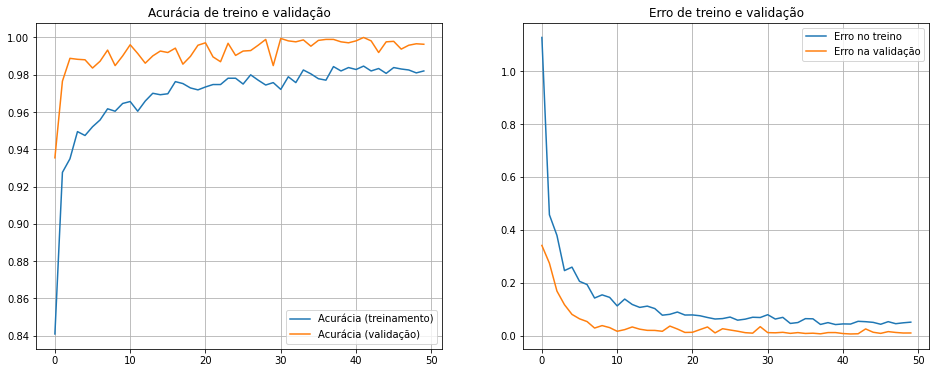

In [13]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(len(loss))

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Acurácia (treinamento)")
plt.plot(epochs_range, val_acc, label="Acurácia (validação)")
plt.legend(loc="lower right")
plt.grid()
plt.title("Acurácia de treino e validação")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Erro no treino")
plt.plot(epochs_range, val_loss, label="Erro na validação")
plt.legend(loc="upper right")
plt.title("Erro de treino e validação")
plt.grid()
plt.show()

{'0-back': [], '1-left': [], '2-front': [], '3-right': []}
total 3840
equal 3826


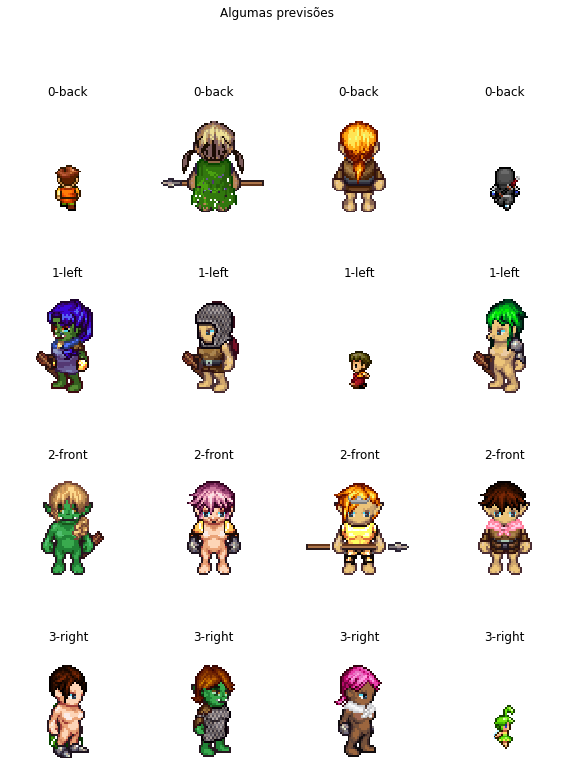

In [14]:
Y_predicted = np.argmax(pose_classifier.predict(X_validation), axis=1).astype(int).reshape(-1, 1)
X_validation_unbatched = np.array(list(X_validation.unbatch().as_numpy_iterator()), dtype=object)
X_validation_unbatched = np.concatenate((X_validation_unbatched, Y_predicted), axis=1)

X_validation_by_class = {name:[] for name in class_names}
print(X_validation_by_class)

total = 0
equal = 0
for (image, y, y_hat) in X_validation_unbatched:
    total += 1
    equal += 1 if y == y_hat else 0
    X_validation_by_class[class_names[y]].append((image, y, y_hat))
    
print('total', total)
print('equal', equal)
    
plt.figure(figsize=(10, 11))
plt.suptitle("Algumas previsões")
plt.subplots_adjust(bottom=0)
for i, class_name in enumerate(class_names):
    indices = np.arange(len(X_validation_by_class[class_names[i]]), dtype="int")
    indices = np.random.choice(indices, size=4, replace=False)
    examples_from_current_class = np.array(X_validation_by_class[class_names[i]], dtype=object)[indices]
    for j in range(4):
        ax = plt.subplot(4, 4, (i*4+j)+1)
        show_normalized_image(examples_from_current_class[j][0])
        plt.title(class_names[examples_from_current_class[j][2]])
        plt.axis("off")

## Estudando previsões incorretas

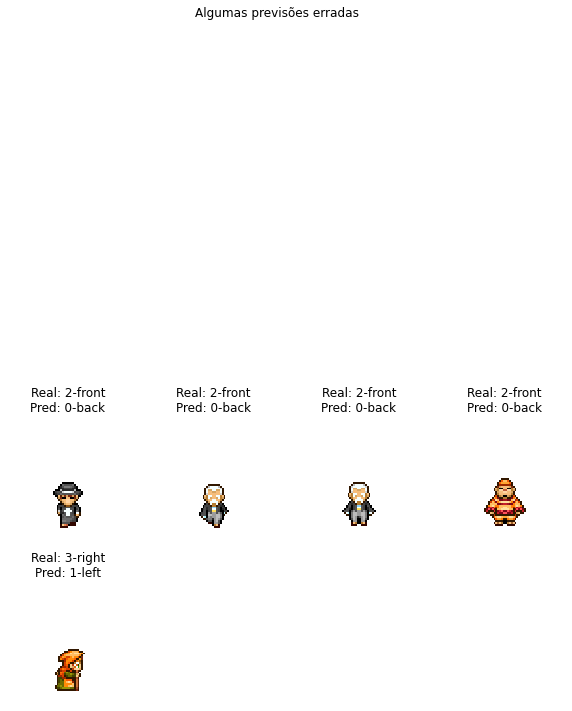

In [15]:
plt.figure(figsize=(10, 10))
plt.suptitle("Algumas previsões erradas")
plt.subplots_adjust(bottom=0)

error_examples = {class_name:[(image, y, y_hat) for (image, y, y_hat) in examples if y != y_hat] for (class_name, examples) in X_validation_by_class.items()}

for i, class_name in enumerate(class_names):
    error_examples_from_current_class = error_examples[class_name]
    number_of_cells = min(4, len(error_examples_from_current_class))
    for j in range(number_of_cells):
        ax = plt.subplot(4, 4, (i*4+j)+1)
        show_normalized_image(error_examples_from_current_class[j][0])
        plt.title(f"Real: {class_names[error_examples_from_current_class[j][1]]}\nPred: {class_names[error_examples_from_current_class[j][2]]}")
        plt.axis("off")
